In [1]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Supplementary functions

def covariance(X,Y):
    '''Calculates biased covariance (or cross covariance) of array-like X and Y'''
    num_samples = len(X[0,:])
    X_centered = mean_center(np.array(X))
    Y_centered = mean_center(np.array(Y))
    return np.matmul(X_centered,Y_centered.T/num_samples)

def mean_center(X):
    '''Centers the mean of rows of X (array-like) around 0.'''
    return np.array([x - np.mean(x) for x in X])

def symmetrize(A):
    '''Numerical safety'''
    return (A + np.transpose(A)) / 2

In [3]:
# Integrators 

def ruku4(function, state, params, dt, steps, noise):
    noise = state.shape[1]*[noise] if state.ndim == 2 else [noise]
    state += np.array([n*np.random.randn(len(n))*np.sqrt(dt) for n in noise]).reshape(state.shape)
    for i in range(steps):
        k1 = dt*function(state,params)
        k2 = dt*function(state+k1/2,params)
        k3 = dt*function(state+k2/2,params)
        k4 = dt*function(state+k3,params)
        state += k1/6. + k2/3. + k3/3. + k4/6.
    return state

def euler_maruyama(function, state, params, dt, steps, noise):
    noise = state.shape[1]*[noise] if state.ndim == 2 else [noise]
    for i in range(steps):
        state += dt*function(state,params) + np.array([n*np.random.randn(len(n))*np.sqrt(dt) for n in noise]).reshape(state.shape)
    return state

def euler(function, state, params, dt, steps, noise):
    noise = state.shape[1]*[noise] if state.ndim == 2 else [noise]
    for i in range(steps):
        state += dt*function(state,params) 
    return state

def test_integrator(function, state, params, dt, steps, noise):
    noise = state.shape[1]*[noise] if state.ndim == 2 else [noise]
    for i in range(steps):
        state += np.zeros_like(state)
    print('In test_integrator')
    return state

In [4]:
class Model:
    def __init__(self):
        self.augmented_state = []
        
    def generate_simulation(self,plot=True):
        '''
        Simulates true and noisy trajectory based on previously 
        defined model and parameter functions
        (Uses global vars)
        '''
#         global observation_sigmas, parameters, augmented_state, Q, R, Pxx, noisy_data

        # Simulate model
        true_state = self.integrate_model()
        self.augmented_state = np.vstack((self.parameters*np.ones(
                    (self.dims_params,self.num_samples)),true_state)) if self.dims_params > 0 else true_state
        self.dims_augmented_state = self.dims_params+self.dims_state_vars

        # Observation noise
        if not self.observation_sigmas:
            self.observation_sigmas = [0.2*0.2*np.var(
                    self.observation_function(self.augmented_state))]
        observation_noise = np.diag(self.observation_sigmas)
        
        # Create noisy data from true trajectory
        self.noisy_data = self.observation_function(self.augmented_state) + np.matmul(
            la.sqrtm(observation_noise), 
            np.random.randn(self.dims_observations,self.num_samples))

        if plot: self.plot_simulated_data()
        
    def integrate_model(self):
        true_state = np.zeros((len(self.initial_conditions),self.num_samples)) # allocate
        true_state[:,0] = self.initial_conditions
        for n in range(self.num_samples-1):
            x_temp = true_state[:,n]
            true_state[:,n+1] = self.integrate(state=x_temp, params=self.parameters[:,n])      
        return true_state

    def plot_simulated_data(self):
        '''Plot simulation'''
        plt.rc('text', usetex=True)
        plt.figure(figsize=(10,2))
        plt.plot(self.noisy_data[0,:],'bd',markeredgecolor='blue', mfc='blue',ms=3,label='noisy data');
        plt.plot(self.observation_function(self.augmented_state).T,'k',linewidth=2,label='actual'); 
        plt.xlabel('t');
        plt.legend();
        plt.axis('tight')
        plt.title('Simulation')
    

In [5]:
class unscented_kalman_filter(Model):
    def __init__(self,model):
        self.model = model
        self.sigma_points = []
        self.results = []
        self.initial_estimate = []
        self.Pxx = np.zeros((model.dims_augmented_state,
                             model.dims_augmented_state,model.num_samples))
        self.set_covariances()
        self.estimated_state = np.zeros((model.dims_augmented_state,model.num_samples)) # estimated trajectory
        self.errors = np.zeros((model.dims_augmented_state, model.num_samples))
        self.Ks = np.zeros((model.dims_augmented_state,
                            model.dims_observations,model.num_samples))

    def set_initial_estimate(self,initial_estimate=None,randrange=[]):
        model = self.model
        if initial_estimate is not None:
            self.estimated_state[:,0] = initial_estimate
        elif randrange and np.all(np.array(randrange) >= 0):
            if len(randrange) == 1:
                r0, rf = 0, int(np.fix(randrange))
            else:
                r0, rf = int(np.fix(randrange[0])), int(np.fix(randrange[1]))
            r = 2*rf
            initial_estimate = -rf + np.random.randint(
                r0,r,model.augmented_state[:,0].shape) + model.augmented_state[:,0]
            self.estimated_state[:,0] = model.set_initial_estimate(initial_estimate)
        elif self.initial_estimate:
            self.estimated_state[:,0] = self.initial_estimate
        else:
            self.estimated_state[:,0] = model.augmented_state[:,0]
    
    def set_covariances(self):
        model = self.model
        sigmas = {}
        sigmas['Q'] = model.process_sigmas
        sigmas['R'] = model.observation_sigmas
        Pxx_init = []
        for n in model.Pxx0:
            Pxx_init = np.hstack((Pxx_init,sigmas[n]))
        Pxx_init = np.diag(Pxx_init)
        self.Q = np.diag(sigmas['Q'])
        self.R = np.diag(sigmas['R'])
        self.Pxx[:,:,0] = Pxx_init

    def generate_sigma_points(self,k):
        '''Why have the extra terms from the Cholesky decomp?? Why not just use sigma in each direction?'''
#         dims = len(self.estimated_state[:,k])
        xhat = self.estimated_state[:,k-1]
        Pxx = self.Pxx[:,:,k-1]
        num_sigma_points = 2*self.model.dims_augmented_state
        Pxx = symmetrize(Pxx)
        xsigma = la.cholesky(self.model.dims_augmented_state*Pxx,lower=True)
        sigma_points = np.hstack((xsigma,-xsigma))
        for i in range(num_sigma_points):
            sigma_points[:,i]+=xhat
        self.sigma_points = sigma_points

    def unscented_kalman(self, initial_estimate=None):
        model = self.model
        self.set_initial_estimate(initial_estimate=initial_estimate)
        for k in range(1,model.num_samples):
            try:
                self.voss_unscented_transform(k)
            except la.LinAlgError:
                self.Pxx[:,:,k-1] = self.Pxx[:,:,k-2]
                self.voss_unscented_transform(k)
            if model.dims_params > 0: self.Pxx[:model.dims_params,:model.dims_params,k] = self.Q
            self.errors[:,k] = np.sqrt(np.diag(self.Pxx[:,:,k]))
            
    
    def voss_unscented_transform(self,k):
        model = self.model
        Pxx = symmetrize(self.Pxx[:,:,k-1])
        self.generate_sigma_points(k)
        sigma_points = self.sigma_points
        
        X = model.transition_function(sigma_points)
        Y = model.observation_function(X).reshape(1,-1)

        Pxx = symmetrize(covariance(X,X))
        Pyy = covariance(Y,Y) + self.R
        Pxy = covariance(X,Y)

        K = np.matmul(Pxy,la.inv(Pyy))
        xhat = np.mean(X,1) + np.matmul(K,(model.noisy_data[:,k] - np.mean(Y,1)))

        Pxx = symmetrize(Pxx - np.matmul(K,Pxy.T))
        
        self.estimated_state[:,k] = xhat
        self.Pxx[:,:,k] = Pxx
        self.Ks[:,:,k] = K
    
    def print_results(self):
        '''Prints results of Kalman filtering.'''
        model = self.model
        results = {}
        results['chisq'] = np.mean(sum((model.augmented_state - self.estimated_state)**2))
        results['est'] = self.estimated_state[:model.dims_params,-1]
        results['error'] = self.errors[:model.dims_params,-1]
        results['meanest'] = np.mean(self.estimated_state[:model.dims_params,:],1)
        results['meanerror'] = np.mean(self.errors[:model.dims_params,:],1)
        for key,value in results.items():
            print('{0:15s}{1}'.format(key+':',str(value)))
        self.results = results
        
    def plot_filter_results(self):
        '''Plots results of Kalman filtering'''
        model = self.model
        plt.rc('text', usetex=True)
        plt.figure(figsize=(10,2))
        for i in range(model.dims_state_vars):
            plt.plot(model.augmented_state[model.dims_params+i,:],lw=2,label=model.var_names[i])
            plt.plot(self.estimated_state[model.dims_params+i,:],'r--',lw=2)
        plt.title('Estimated State Variables')
        plt.legend()
        plt.xlabel('t/dt')
        plt.axis('tight')

        plt.figure(figsize=(10,2))
        for i in range(model.dims_params):
            plt.plot(model.augmented_state[i,:],'k',linewidth=2,label=model.parameter_names[i])
            plt.plot(self.estimated_state[i,:],'m',linewidth=2)
            plt.plot(self.estimated_state[i,:] + self.errors[i,:],'m')
            plt.plot(self.estimated_state[i,:] - self.errors[i,:],'m')
        plt.title('Estimated Parameters')
        plt.legend()
        plt.xlabel('t/dt')
        plt.axis('tight')
        plt.show()

In [6]:
class epileptor_model(Model):
    def __init__(self):
        self._model = 'epileptor'
        
#     def get_num_samples(self,time,dt):
#         return int(time//dt)
    
    def get_steps_per_sample(self,dt_sample,dt_integrate):
        return int(dt_sample//dt_integrate)
            
    var_names = ['x1','y1','z','x2','y2','g']
    parameter_names = ['x0']

    dims_params = 1
    dims_state_vars = 6
    dims_observations = 1
    dims_augmented_state = dims_params + dims_state_vars

    noise = [0.025, 0., 0., 0.25, 0., 0.]

    process_sigmas = [0.015]
    observation_sigmas = [] # empty array will use sim data to generate observation_sigmas
    Pxx0 = 'QRRRRRR'

    total_time = 10 # 2500 for epileptor, 160 for FN
    dt_sample = 0.1
    dt_integrate = dt_sample
    
    __num_samples = int(total_time//dt_sample)
    
    def _set_dt_sample(self,dt):
        self.__dt_sample = dt
        self.__num_samples = self.get_num_samples()
#     def get_num_samples()
    
    @property
    def num_samples(self):
        self.__num_samples = int(self.total_time//self.dt_sample)
        return self.__num_samples
    
#     dt_sample = property(lambda(self): return self.__dt_sample,_set_dt_sample(self,dt))
#     num_samples = get_num_samples([],total_time,dt_sample)
    steps_per_sample = get_steps_per_sample([],dt_sample,dt_integrate)

#     parameters = parameter_function(num_samples).reshape(dims_params,num_samples)
#     def epileptor_parameters(num_samples):
#     global y0, tau0, tau1, tau2, Irest1, Irest2, gamma, noise, initial_conditions

    '''x0 is tracked parameter'''
    x0, y0 = -1.6, 1.
    tau0, tau1, tau2 = 2875., 1., 10.
    Irest1, Irest2 = 3.1, 0.45
    gamma = 0.01
    initial_conditions = [0.,-5.,3.,0.,0.,0.]
    noise = [0.025, 0.0, 0., .25, 0., 0.]
    
    x0_parameter = (x0*np.ones(__num_samples)).reshape(1,__num_samples)
    parameters = x0_parameter

    integrator = 'ruku4'
    
    test_prop = property(lambda self: 0)
    
    def fix_integration_parameters(self): 
#         self.num_samples = int(self.total_time//self.dt_sample)
        self.num_samples = self.get_num_samples(self.total_time,self.dt_sample)
        self.x0_parameter = (self.x0*np.ones(self.num_samples)).reshape(1,self.num_samples)
        self.parameters = self.x0_parameter
        self.steps_per_sample = self.get_steps_per_sample(self.dt_sample,self.dt_integrate)

    def integrate(self,state,params):
        switcher = {
            'ruku4': ruku4,
            'euler': euler,
            'euler_maruyama': euler_maruyama,
            'test_integrator': test_integrator
        }
        return switcher[self.integrator](self.model_function,state,params,
                          self.dt_integrate,self.steps_per_sample,self.noise)
    
    def model_function(self,state,parameters):
        x1, y1, z, x2, y2, g = state 
        x0 = parameters.reshape(x1.shape)
        x1_dot = y1 - self.f1(x1,x2,z) - z + self.Irest1
        y1_dot = self.y0 - 5.*x1*x1 - y1
        z_dot = 1/self.tau0*(4*(x1 - x0) - z)
        x2_dot = -y2 + x2 - x2**3 + self.Irest2 + 2.*g - 0.3*(z - 3.5)
        y2_dot = 1/self.tau2*(-y2 + self.f2(x2))
        g_dot = -self.gamma*(g - 0.1*x1)
        return np.array([x1_dot, y1_dot, z_dot, x2_dot, y2_dot, g_dot])
    
    def observation_function(self,augmented_state):
        x1 = augmented_state[self.dims_params,:]
        x2 = augmented_state[self.dims_params+3,:]
        return -x1 + x2
    
    def set_initial_estimate(self,initial_estimate):
        x1 = self.noisy_data[0,0]/2.
        x2 = self.noisy_data[0,0]/2. + x1
        initial_estimate[self.dims_params] = x1
        initial_estimate[self.dims_params+3] = x2
        return initial_estimate

    def transition_function(self, augmented_state):
        parameters, state = np.split(augmented_state,[self.dims_params,])
        state = ruku4(self.model_function,state,parameters,self.dt_integrate,
                      self.steps_per_sample,self.noise)
        return np.vstack((parameters,state))

    def f1(self,x1,x2,z):
        return ( x1**3 - 3*x1**2 ) * (x1 < 0) + ( x1*(x2 - 0.6*(z-4)**2) ) * (x1 >=0)

    def f2(self,x2):
        return 0 * (x2 < -0.25) + ( 6*(x2 + 0.25) ) * (x2 >= -0.25)
    

In [21]:
class FN_model(Model):
    def __init__(self):
        self._model = 'Fitzhugh-Nagumo'
        
#     def get_num_samples(self,time,dt):
#         return int(time//dt)
    
    def get_steps_per_sample(self,dt_sample,dt_integrate):
        return int(dt_sample//dt_integrate)
            
    var_names = ['v','w']
    parameter_names = ['I', 'a', 'b']

    dims_params = 3
    dims_state_vars = 2
    dims_observations = 1
    dims_augmented_state = dims_params + dims_state_vars

    noise = [0.0, 0.]

    process_sigmas = [0.015]
    observation_sigmas = [70e-3] # empty array will use sim data to generate observation_sigmas
    Pxx0 = 'QQQRR'

    total_time = 160 # 2500 for epileptor, 160 for FN
    dt_sample = 0.2
    dt_integrate = dt_sample
    
    __num_samples = int(total_time//dt_sample)
    
    def _set_dt_sample(self,dt):
        self.__dt_sample = dt
        self.__num_samples = self.get_num_samples()
#     def get_num_samples()
    
    @property
    def num_samples(self):
        self.__num_samples = int(self.total_time//self.dt_sample)
        return self.__num_samples
    
#     dt_sample = property(lambda(self): return self.__dt_sample,_set_dt_sample(self,dt))
#     num_samples = get_num_samples([],total_time,dt_sample)
    steps_per_sample = get_steps_per_sample([],dt_sample,dt_integrate)

#     parameters = parameter_function(num_samples).reshape(dims_params,num_samples)
#     def epileptor_parameters(num_samples):
#     global y0, tau0, tau1, tau2, Irest1, Irest2, gamma, noise, initial_conditions

    '''x0 is tracked parameter'''
    a = 0.7 
    b, c = 0.8, 3.
    initial_conditions = [0., 0.]
    
    Iext = np.arange(1,__num_samples+1)/250.*2*np.pi
    Iext = -0.4 - 1.01*(np.abs(np.sin(Iext/2.)))
    a *= np.ones_like(Iext)
    b *= np.ones_like(Iext)
    parameters = np.vstack((Iext, a, b))
#     parameters = np.vstack((Iext)).T

    integrator = 'ruku4'
        
        
    def integrate(self,state,params):
        switcher = {
            'ruku4': ruku4,
            'euler': euler,
            'euler_maruyama': euler_maruyama,
            'test_integrator': test_integrator
        }
        return switcher[self.integrator](self.model_function, state, params,
                          self.dt_integrate, self.steps_per_sample, self.noise)
    
    def model_function(self, state, parameters):
#         a = self.a
#         b = self.b
        c = self.c
        v, w = state
        input_current, a, b = parameters
#         input_current = input_current.reshape(1, -1)
        return np.array([c*(w+v-v**3/3+input_current), -(v-a+b*w)/c]);
    
    def observation_function(self,augmented_state):
        return augmented_state[-2, :].reshape(1,len(augmented_state[1, :]))
    
#     def set_initial_estimate(self,initial_estimate):
#         initial_estimate = np.zeros_like(initial_estimate)
#         initial_estimate[self.dims_params + 1] = \
#             self.noisy_data[self.dims_params + 1, 0]
#         return initial_estimate

    def transition_function(self, augmented_state):
        dims_params = self.dims_params
        dt_integrate = self.dt_integrate
        steps_per_sample = self.steps_per_sample
        
        parameters, state = np.split(augmented_state,[dims_params,])
        state = ruku4(self.model_function, state, parameters,
                      dt_integrate, steps_per_sample, self.noise)
        return np.vstack((parameters,state))


In [30]:
kf.Q

array([[ 0.015]])

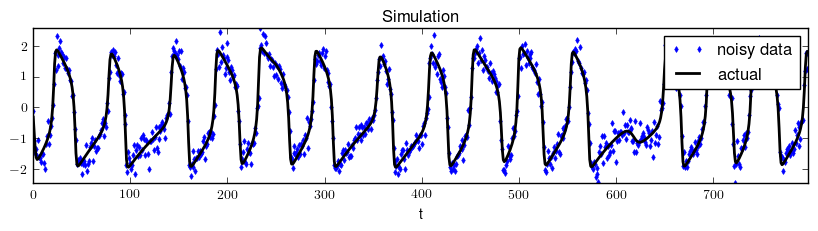

In [36]:
p = FN_model()
# p.parameters[:,1]
p.generate_simulation()
# plt.plot(p.noisy_data.T)

In [37]:
kf = unscented_kalman_filter(p)

In [38]:
# kf.unscented_kalman(initial_estimate=[0., 0., 0., 0.])
kf.unscented_kalman()

In [39]:
kf.estimated_state[:,0]

array([-0.4126917 ,  0.7       ,  0.8       , -0.3183572 ,  0.05503904])

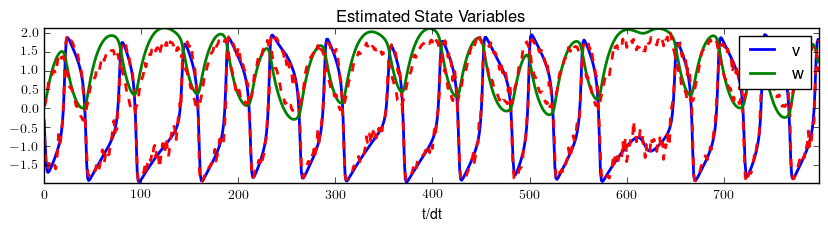

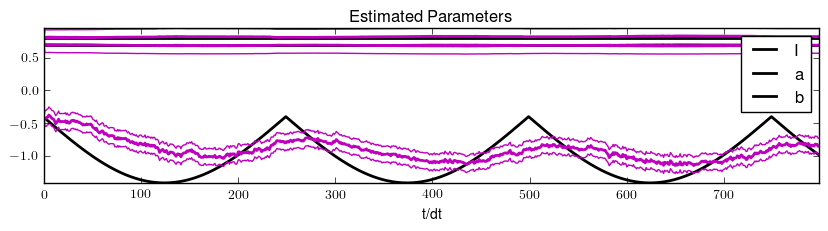

In [40]:
kf.plot_filter_results()

In [14]:
def vossFNint(state,parameters):
    '''Fitzhugh-Nagumo model'''
    v, w = state
    input_current = parameters
    input_current = input_current.reshape(v.shape)
    return np.array([c*(w+v-v**3/3+input_current), -(v-a+b*w)/c]);

def vossFNobsfct(augmented_state):
    return augmented_state[-2,:].reshape(1,len(augmented_state[1,:]))

def vossFNfct(dims_params, augmented_state):
    parameters, state = np.split(augmented_state,[dims_params,])
    state = ruku4(vossFNint,state,parameters,dt_integrate,steps_per_sample)
    return np.vstack((parameters,state))
    
def vossFNparams(num_samples):
    global a, b, c, initial_conditions
    a, b, c = 0.7, 0.8, 3.
    initial_conditions = [0., 0.]
    
    Iext = np.arange(1,num_samples+1)/250.*2*np.pi
    Iext = -0.4 - 1.01*(np.abs(np.sin(Iext/2.)))
#     a = 0.7*np.ones_like(Iext)
#     parameters = np.vstack((Iext,a))
    parameters = np.vstack((Iext))
    return parameters.reshape(1,num_samples)


In [15]:
# Set parameters for simulation and filtering

model_function = vossFNint
transition_function = vossFNfct
observation_function = vossFNobsfct
parameter_function = vossFNparams

integrator = ruku4

In [16]:
def unscented_kalman(p=epileptor_model()):
    '''Uses global vars for now'''
    global estimated_state, Pxx, Ks, errors        
    for k in range(1,p.num_samples):
        try:
            estimated_state[:,k],Pxx[:,:,k],Ks[:,:,k] = voss_unscented_transform(p,
                estimated_state[:,k-1],p.Pxx[:,:,k-1],p.noisy_data[:,k],
                transition_function,observation_function,p.dims_params,p.dims_augmented_state,
                p.dims_observations, R)
        except la.LinAlgError:
            Pxx[:,:,k-1] = Pxx[:,:,k-2]
            estimated_state[:,k],Pxx[:,:,k],Ks[:,:,k] = voss_unscented_transform(p,
                estimated_state[:,k-1],Pxx[:,:,k-1],noisy_data[:,k],
                transition_function,observation_function,p.dims_params,p.dims_augmented_state,
                p.dims_observations, R)
        if dims_params > 0: Pxx[:p.dims_params,:p.dims_params,k] = Q
        errors[:,k] = np.sqrt(np.diag(Pxx[:,:,k]))
    
        
def print_results(p,augmented_state,estimated_state):
    '''Prints results of Kalman filtering.'''
    results = {}
    results['chisq'] = np.mean(sum((augmented_state - estimated_state)**2))
    results['est'] = estimated_state[:p.dims_params,-1]
    results['error'] = errors[:p.dims_params,-1]
    results['meanest'] = np.mean(estimated_state[:p.dims_params,:],1)
    results['meanerror'] = np.mean(errors[:p.dims_params,:],1)
    for key,value in results.items():
        print('{0:15s}{1}'.format(key+':',str(value)))
    return results

def plot_simulated_data(p=epileptor_model()):
    '''Plot simulation'''
    plt.rc('text', usetex=True)
    plt.figure(figsize=(10,2))
    plt.plot(noisy_data[0,:],'bd',markeredgecolor='blue', mfc='blue',ms=3,label='noisy data');
    plt.plot(observation_function(p,augmented_state).T,'k',linewidth=2,label='actual'); 
    plt.xlabel('t');
    plt.legend();
    plt.axis('tight')
    plt.title('Simulation')
        
def plot_filter_results(p=epileptor_model()):
    '''Plots results of Kalman filtering'''
    plt.rc('text', usetex=True)
    plt.figure(figsize=(10,2))
    for i in range(p.dims_state_vars):
        plt.plot(augmented_state[p.dims_params+i,:],lw=2,label=p.var_names[i])
        plt.plot(estimated_state[p.dims_params+i,:],'r--',lw=2)
    plt.title('Estimated State Variables')
    plt.legend()
    plt.xlabel('t/dt')
    plt.axis('tight')

    plt.figure(figsize=(10,2))
    for i in range(p.dims_params):
        plt.plot(augmented_state[i,:],'k',linewidth=2,label=p.parameter_names[i])
        plt.plot(estimated_state[i,:],'m',linewidth=2)
        plt.plot(estimated_state[i,:] + errors[i,:],'m')
        plt.plot(estimated_state[i,:] - errors[i,:],'m')
    plt.title('Estimated Parameters')
    plt.legend()
    plt.xlabel('t/dt')
    plt.axis('tight')
    plt.show()

In [17]:
# Unscented Kalman Filter
num_samples = p.num_samples
dims_observations = p.dims_observations
dims_params = p.dims_params
dims_augmented_state = p.dims_augmented_state

# Preallocate arrays
estimated_state = np.zeros((dims_augmented_state,num_samples)) # estimated trajectory
errors = np.zeros((dims_augmented_state, num_samples))
Ks = np.zeros((dims_augmented_state,dims_observations,num_samples))

# Initialize estimated state
estimated_state[:,0] = augmented_state[:,0]
# r = 6
# estimated_state[:,0] = -r/2. + np.random.randint(1,r,augmented_state[:,0].shape) + augmented_state[:,0]
# estimated_state[dims_params,0] = noisy_data[0,0]/2.
# estimated_state[dims_params+3,0] = noisy_data[0,0]/2. + estimated_state[dims_params,0]

# Main loop for recursive estimation
unscented_kalman(p)

# Results
print_results(p,augmented_state,estimated_state)

# Plotting
plot_filter_results(p)

NameError: name 'augmented_state' is not defined

In [ ]:
# Test: mean_center 
A = np.random.randn(3,4)
A0 = mean_center(A)
assert np.allclose(np.mean(A0,1),0)

# Test: symmetrize
A = np.random.randn(3,3)
assert (symmetrize(A) == np.transpose(symmetrize(A))).all()

# Test: covariance
A = np.array(np.random.randn(2,10))
B = np.array(np.random.randn(1,10))
assert np.allclose(covariance(A,A),np.cov(A,bias=True))

# Test: generate_sigma_points


In [35]:
import logging
import numpy as np
import integrators
import matplotlib.pyplot as plt
from integrators import ruku4
import scipy.linalg as la
from epileptor_util import Model


logging.basicConfig(level=logging.WARN)

# Note: having debug logging statements increases the run time by ~ 25%,
# because they exist in tight loops, and expand their outputs, even when
# debug is off, so we disable logging if possible.  Set this to true if
# verbose output is needed
LOGGING_DEBUG = True

plot = True


def logging_debug_vec(fmt, vec):
    '''log to debug a vector'''
    if LOGGING_DEBUG:
        logging.debug(fmt, ', '.join(map(str, vec)))


def logging_debug(*args):
    '''wrapper to log to debug a vector'''
    if LOGGING_DEBUG:
        logging.debug(*args)


def covariance(X, Y):
    '''Calculates biased covariance (or cross covariance)
    of array-like X and Y'''
    num_samples = len(X[0, :])
    X_centered = mean_center(np.array(X))
    Y_centered = mean_center(np.array(Y))
    return np.matmul(X_centered, Y_centered.T / num_samples)


def mean_center(X):
    '''Centers the mean of rows of X (array-like) around 0.'''
    return np.array([x - np.mean(x) for x in X])


def symmetrize(A):
    '''Numerical safety'''
    return (A + np.transpose(A)) / 2


def create_sigma_list(value, dim):
    if type(value) in [float, int]:
        return list(value * np.ones(dim))
    else:
        value = list(value)
        while len(value) < dim:
            value.append(1e-16)
        return value[:dim]


def keep_in_bounds(value, bounds=(-30, 30)):
    type_temp = type(value)
    value = np.array(value)
    value[value < bounds[0]] = bounds[0]
    value[value > bounds[1]] = bounds[1]
    return type_temp(value) if type_temp != np.ndarray else value


class unscented_kalman_filter(Model):
    def __init__(self, model, parameter_sigma=15e-3, state_sigma=15e-3):
        self.model = model
        self.parameter_sigma = parameter_sigma
        self.state_sigma = state_sigma
        self.sigma_points = []
        self.results = []
        self.initial_estimate = []
        self.set_covariances()
        self.estimated_state = np.zeros((model.dims_augmented_state,
                                         model.num_samples))
        self.errors = np.zeros((model.dims_augmented_state, model.num_samples))
        self.Ks = np.zeros((model.dims_augmented_state,
                            model.dims_observations, model.num_samples))

    def set_initial_estimate(self, initial_estimate=None, randrange=0.):
        model = self.model
        if initial_estimate is None:
            initial_estimate = 'model'
        switcher = {
            'model': model.set_initial_estimate(
                np.zeros(model.dims_augmented_state)),
            'zeros': np.zeros(model.dims_augmented_state),
            'exact': model.augmented_state[:, 0]
        }
        if type(initial_estimate) == str:
            self.estimated_state[:, 0] = switcher[initial_estimate]
        else:
            self.estimated_state[:, 0] = \
                create_sigma_list(initial_estimate, model.dims_augmented_state)
        if randrange > 0:
            random_smear = np.random.rand(model.dims_augmented_state) * \
                randrange * 2 - randrange
            self.estimated_state[:, 0] += random_smear
        for i in range(model.dims_params):
            sigmas = self.Q
            if sigmas[i] < 1e-15:
                self.estimated_state[i, 0] = model.augmented_state[i, 0]

        # if initial_estimate:
        #     self.estimated_state[:, 0] = initial_estimate
        # elif randrange and np.all(np.array(randrange) >= 0):
        #     if len(randrange) == 1:
        #         r0, rf = 0, int(np.fix(randrange))
        #     else:
        #         r0, rf = int(np.fix(randrange[0])), int(np.fix(randrange[1]))
        #     r = 2 * rf
        #     initial_estimate = -rf + np.random.randint(
        #         r0, r, model.augmented_state[:, 0].shape) + \
        #         model.augmented_state[:, 0]
        #     self.estimated_state[:, 0] = \
        #         model.set_initial_estimate(initial_estimate)
        # elif self.initial_estimate:
        #     self.estimated_state[:, 0] = self.initial_estimate
        # else:
        #     self.estimated_state[:, 0] = model.augmented_state[:, 0]

    def set_covariances(self):
        model = self.model
        self.Pxx = np.zeros((model.dims_augmented_state,
                             model.dims_augmented_state, model.num_samples))
        # sigmas = {}
        # sigmas['Q'] = self.parameter_sigma
        # sigmas['R'] = self.state_sigma
        # Pxx_init = []
        # for n in model.Pxx0:
        #     Pxx_init = np.hstack((Pxx_init, sigmas[n]))
        # Pxx_init = np.diag(Pxx_init)
        # self.Q = np.diag(sigmas['Q'])
        # self.R = np.diag(sigmas['R'])
        self.Q = keep_in_bounds(create_sigma_list(
            self.parameter_sigma, model.dims_params),
            bounds=(1e-16, 100))
        self.R = keep_in_bounds(create_sigma_list(
            self.state_sigma, model.dims_state_vars),
            bounds=(1e-16, 100))
        # self.Pxx[:, :, 0] = Pxx_init
        self.Pxx[:, :, 0] = np.diag(np.hstack((self.Q, self.R)))

    def generate_sigma_points(self, k):
        '''Why have the extra terms from the Cholesky decomp??
        Why not just use sigma in each direction?'''
#         dims = len(self.estimated_state[:,k])
        xhat = self.estimated_state[:, k - 1]
        Pxx = self.Pxx[:, :, k - 1]
        num_sigma_points = 2 * self.model.dims_augmented_state
        Pxx = symmetrize(Pxx)
        xsigma = la.cholesky(self.model.dims_augmented_state * Pxx, lower=True)
        sigma_points = np.hstack((xsigma, -xsigma))
        for i in range(num_sigma_points):
            sigma_points[:, i] += xhat
        self.sigma_points = sigma_points

    def unscented_kalman(self, initial_estimate=[]):
        model = self.model
        self.set_initial_estimate(initial_estimate=initial_estimate)
        for k in range(1, model.num_samples):
            self.k = k
            try:
                self.voss_unscented_transform(k)
            except la.LinAlgError:
                logging_debug('LinAlgError\nk: {}\nPxx: {}'.format(
                    k, self.Pxx[:, :, k - 1]))
                self.Pxx[:, :, k - 1] = self.Pxx[:, :, k - 2]
                self.voss_unscented_transform(k)
            if model.dims_params > 0:
                self.Pxx[:model.dims_params, :model.dims_params, k] = \
                    np.diag(self.Q)
            self.errors[:, k] = np.sqrt(np.diag(self.Pxx[:, :, k]))

    def voss_unscented_transform(self, k):
        model = self.model
        Pxx = symmetrize(self.Pxx[:, :, k - 1])
        self.generate_sigma_points(k)
        sigma_points = self.sigma_points

        X = model.transition_function(sigma_points)
        Y = model.observation_function(X).reshape(1, -1)

        Pxx = symmetrize(covariance(X, X))
        Pyy = covariance(Y, Y) + self.state_sigma
        Pxy = covariance(X, Y)

        K = np.matmul(Pxy, la.inv(Pyy))
        xhat = np.mean(X, 1) + \
            np.matmul(K, (model.noisy_data[:, k] - np.mean(Y, 1)))

        Pxx = symmetrize(Pxx - np.matmul(K, Pxy.T))

        self.estimated_state[:, k] = keep_in_bounds(xhat)
        self.Pxx[:, :, k] = keep_in_bounds(Pxx, bounds=(-100, 100))
        self.Ks[:, :, k] = K

    def print_results(self):
        '''Prints results of Kalman filtering.'''
        model = self.model
        results = {}
        results['chisq'] = \
            np.mean(sum((model.augmented_state - self.estimated_state)**2))
        results['est'] = self.estimated_state[:model.dims_params, -1]
        results['error'] = self.errors[:model.dims_params, -1]
        results['meanest'] = \
            np.mean(self.estimated_state[:model.dims_params, :], 1)
        results['meanerror'] = np.mean(self.errors[:model.dims_params, :], 1)
        for key, value in results.items():
            print('{0:15s}{1}'.format(key + ':', str(value)))
        self.results = results

    def plot_filter_results(self, separated=False):
        '''Plots results of Kalman filtering'''
        model = self.model
        plt.rc('text', usetex=True)
        plt.figure(figsize=(10, 2))
        for i in range(model.dims_state_vars):
            if separated and i > 0:
                plt.figure(figsize=(10, 2))
            plt.plot(model.augmented_state[model.dims_params + i, :],
                     lw=2, label=model.var_names[i])
            plt.plot(self.estimated_state[model.dims_params + i, :],
                     'r--', lw=2)
            if separated:
                plt.title(model.var_names[i])
                plt.xlabel('t/dt')
                plt.axis('tight')
                plt.show()
        if not separated:
            plt.title('Estimated State Variables')
            plt.legend()
            plt.xlabel('t/dt')
            plt.axis('tight')
            plt.show()
        plt.figure(figsize=(10, 2))
        plt.plot(model.noisy_data[0], 'k')
        plt.plot(model.observation_function(self.estimated_state), 'r')
        plt.title('Observed Results')
        plt.axis('tight')
        plt.xlabel('t/dt')
        plt.show()

        for i in range(model.dims_params):
            if self.Q[i] < 1e-15:
                continue
            if i == 0 or (separated and i > 0):
                plt.figure(figsize=(10, 2))
            plt.plot(model.augmented_state[i, :], 'k',
                     linewidth=2, label=model.parameter_names[i])
            plt.plot(self.estimated_state[i, :], 'm', linewidth=2)
            plt.plot(self.estimated_state[i, :] + self.errors[i, :], 'm')
            plt.plot(self.estimated_state[i, :] - self.errors[i, :], 'm')
            if separated:
                plt.title(model.parameter_names[i])
                plt.xlabel('t/dt')
                plt.axis('tight')
                plt.show()
        if not separated:
            plt.title('Estimated Parameters')
            plt.legend()
            plt.xlabel('t/dt')
            plt.axis('tight')
            plt.show()


ImportError: No module named 'integrators'